https://github.com/NanoComp/meep/blob/master/python/examples/straight-waveguide.ipynb  

https://stackoverflow.com/questions/29454002/filenotfounderror-errno-2-no-such-file-or-directory-ffmpeg


In [1]:
import math
import meep as mp
from meep import mpb

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def phc_trans(PhC = True, lengthPhC = 100, decay_check=0):
    """
    <変数の説明>
    PhC...PhC(フォトニック決勝)を配置するかどうか。Falseで直線導波路
    lengthPhC...PhC導波方向の長さ
    widthPhC...PhC垂直方向の幅。PMLと被ってるので適当。
    ConnectionWaveguide...PhCに接続するSi導波路(棒の部分)の長さ
    wgi...導波路の幅を調整する。1で丸穴一個分空いてることを意味する。0.7とかにすると狭くなってバンドの形が変わる、っていうのはDaii君の研究とも絡む。
    r...穴の半径。ふつうはa/4くらい。meepだと格子定数は1で固定だから、格子定数との比を入力すればOK
    n_eff...屈折率。2次元だと2.5~2.7くらいにしておくと3次元のSi系(n_Si=3.48)と結果が近くなる。違う材料を使うときは要調整、通常はdefaultで大丈夫。
    fcen...入力光（ガウシアンビーム）の中心周波数。知りたいPhCバンドの周波数近くに設定する
    df...入力光（ガウシアンビーム）の半値幅（で合ってる？）
    nfreq...入力光（ガウシアンビーム）のきめ細かさ
    resolution...メッシュの細かさ。2^nにすると計算が軽くなるらしい。
    T_dacay...反復計算数。小さいと誤差が増え、大きいと時間がかかる。sim.run(until_after_sources=...)で計算時間を見積もってから変えるとよさそう
    decay_check...解の収束をどこで判定するか、位置を指定。defaultでOK

    <備考>
    ・meepでは格子定数aはパラメータに含まれないので設定不要
    　誘電体を使うときは入力するらしい（スケール依存性が出るから）
    ・THzやnmは使用せず、すべて規格化周波数で入力する (周波数はωa/2πcで直す)
    """
    ##### setting of parameters #####
    widthPhC = 20
    ConnectionWaveguide = 5
    wgi = 1
    r = 1/4
    n_eff = 2.6
    fcen = 0.3 
    df = 0.1
    nfreq = 500 # number of frequencies at which to compute flux
    resolution = 16
    T_decay = 10000
    
    #####
    length = lengthPhC + 2*ConnectionWaveguide
    width = widthPhC
    Nx = int(lengthPhC)
    Ny = int(widthPhC)
    eps = n_eff**2

    ##### settings of geometry #####
    # initialization
    cell = mp.Vector3(length,width*np.sqrt(3),0)

    # Si waveguide
    waveguide = mp.Block(mp.Vector3(mp.inf,wgi*np.sqrt(3),mp.inf),
                         center=mp.Vector3(),
                         material=mp.Medium(epsilon=eps))
    geometry = [waveguide]

    # PhC
    if PhC:
        # slab
        blk = mp.Block(mp.Vector3(lengthPhC,widthPhC*np.sqrt(3),mp.inf),
                             center=mp.Vector3(),
                             material=mp.Medium(epsilon=eps))

        geometry.append(blk)
        
        # arrange air-holes
        for j in range(Ny):
            for i in range(Nx+1):
                shift_y = np.sqrt(3)
                geometry.append(mp.Cylinder(r, center=mp.Vector3(i-Nx/2, wgi*np.sqrt(3)/2 + shift_y*j)))
                geometry.append(mp.Cylinder(r, center=mp.Vector3(i-Nx/2, -(wgi*np.sqrt(3)/2 + shift_y*j))))

                geometry.append(mp.Cylinder(r, center=mp.Vector3(i-(Nx+1)/2, wgi*np.sqrt(3)/2 + shift_y*(j+1/2))))
                geometry.append(mp.Cylinder(r, center=mp.Vector3(i-(Nx+1)/2, -(wgi*np.sqrt(3)/2 + shift_y*(j+1/2)))))
                #geometry.append(mp.Cylinder(r, center=mp.Vector3(i-N/2,-wgi*np.sqrt(3)/2)))
    
    # Gaussian
    sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                         component=mp.Hz,
                         center=mp.Vector3(-length/2 +1,0),
                         size=mp.Vector3(0,wgi*np.sqrt(3)))
              ]

    # PML
    pml_layers = [mp.PML(1.0)]

    # z-symmetry (上下対称なら計算が軽くなる。対称性が無いなら消す)
    sym = [mp.Mirror(mp.Y, phase=-1)]
    

    ####
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=sources,
                        symmetries=sym,
                        resolution=resolution)

    #tran_in = mp.FluxRegion(center=mp.Vector3(-lengthPhC/2-1,0),size=mp.Vector3(0, 2*wgi))
    tran_out = mp.FluxRegion(center=mp.Vector3(length/2-3/2,0),size=mp.Vector3(0, 2*wgi))
    #trans_in = sim.add_flux(fcen, df, nfreq, tran_in)
    trans_out = sim.add_flux(fcen, df, nfreq, tran_out)

    # show geometry
    %matplotlib inline
    f = plt.figure(dpi=150)
    sim.plot2D(ax=f.gca())
    plt.show()    

    #sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(decay_check), 1e-3))
    sim.run(until=T_decay)

    freqs = mp.get_flux_freqs(trans_out)
    #psd_in = mp.get_fluxes(trans_in)
    psd_out = mp.get_fluxes(trans_out)

    return freqs, psd_out


-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.00151205 s
Working in 2D dimensions.
Computational cell is 30 x 34.625 x 0 with resolution 16
     block, center = (0,0,0)
          size (1e+20,1.73205,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
time for set_epsilon = 0.204138 s
-----------


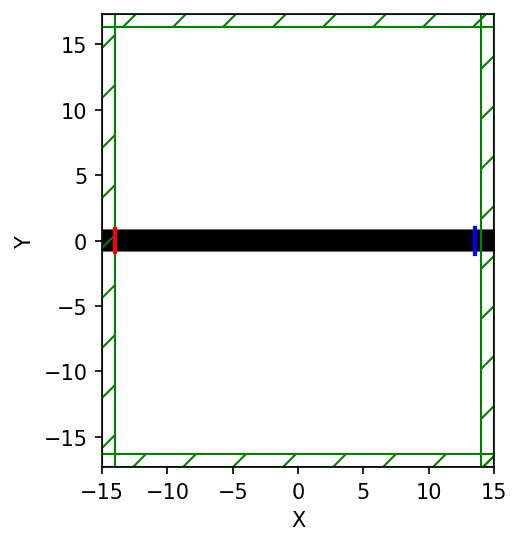

Meep progress: 103.34375/10000.0 = 1.0% done in 4.0s, 383.3s to go
on time step 3307 (time=103.344), 0.00121046 s/step
Meep progress: 202.625/10000.0 = 2.0% done in 8.0s, 387.0s to go
on time step 6485 (time=202.656), 0.00125887 s/step
Meep progress: 278.34375/10000.0 = 2.8% done in 12.0s, 419.3s to go
on time step 8909 (time=278.406), 0.0016502 s/step
Meep progress: 384.6875/10000.0 = 3.8% done in 16.0s, 400.1s to go
on time step 12312 (time=384.75), 0.00117549 s/step
Meep progress: 483.1875/10000.0 = 4.8% done in 20.0s, 394.0s to go
on time step 15464 (time=483.25), 0.00126916 s/step
Meep progress: 595.8125/10000.0 = 6.0% done in 24.0s, 378.9s to go
on time step 19069 (time=595.906), 0.00110967 s/step
Meep progress: 710.3125/10000.0 = 7.1% done in 28.0s, 366.3s to go
on time step 22733 (time=710.406), 0.00109177 s/step
Meep progress: 825.125/10000.0 = 8.3% done in 32.0s, 355.9s to go
on time step 26405 (time=825.156), 0.00108954 s/step
Meep progress: 932.25/10000.0 = 9.3% done in 36.

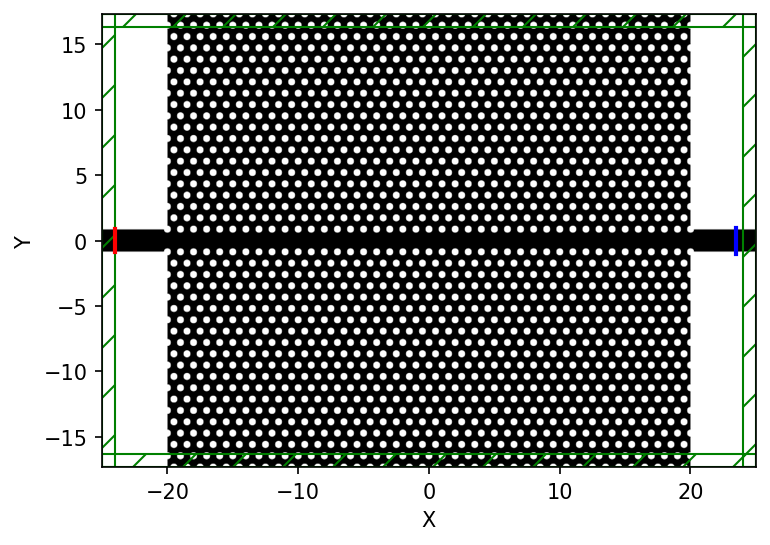

0223522 s/step
Meep progress: 1564.65625/10000.0 = 15.6% done in 132.0s, 711.9s to go
on time step 50080 (time=1565), 0.00254688 s/step
Meep progress: 1599.4375/10000.0 = 16.0% done in 136.0s, 714.6s to go
on time step 51194 (time=1599.81), 0.00359334 s/step
Meep progress: 1642.3125/10000.0 = 16.4% done in 140.1s, 712.7s to go
on time step 52568 (time=1642.75), 0.00291265 s/step
Meep progress: 1689.9375/10000.0 = 16.9% done in 144.1s, 708.4s to go
on time step 54093 (time=1690.41), 0.00262419 s/step
Meep progress: 1743.1875/10000.0 = 17.4% done in 148.1s, 701.3s to go
on time step 55798 (time=1743.69), 0.00234676 s/step
Meep progress: 1795.46875/10000.0 = 18.0% done in 152.1s, 694.8s to go
on time step 57471 (time=1795.97), 0.0023914 s/step
Meep progress: 1850.90625/10000.0 = 18.5% done in 156.1s, 687.1s to go
on time step 59246 (time=1851.44), 0.00225454 s/step
Meep progress: 1905.09375/10000.0 = 19.1% done in 160.1s, 680.1s to go
on time step 60980 (time=1905.62), 0.00230743 s/step
M

In [4]:
freqs_wo, psd_out_wo = phc_trans(PhC = False, lengthPhC = 20, decay_check=10)
freqs_w,  psd_out_w  = phc_trans(PhC = True, lengthPhC = 40, decay_check=20)

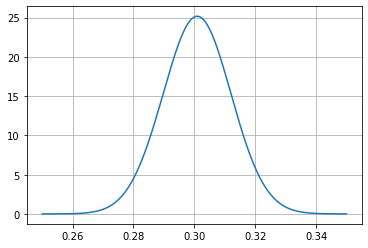

In [5]:
plt.plot(freqs_wo,psd_out_wo)
plt.grid(True)

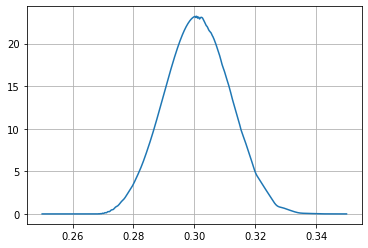

In [6]:
plt.plot(freqs_w,psd_out_w)
plt.grid(True)

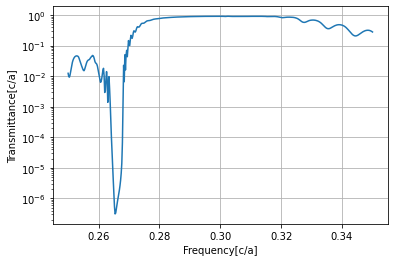

In [7]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

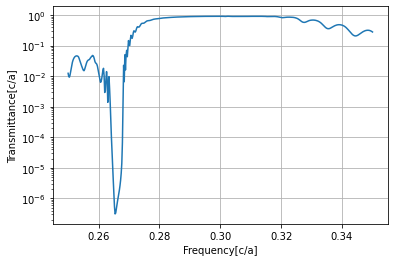

In [8]:
plt.plot(np.array(freqs_w), np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
plt.yscale('log')
plt.grid(True)

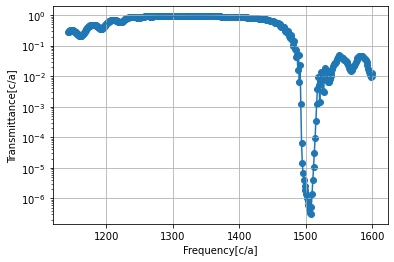

In [9]:
a = 400
c_const = 299792458

freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)

In [ ]:
a = 400
c_const = 299792458

freqs = a / np.array(freqs_w)
#freqs
plt.plot(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.scatter(freqs, np.array(psd_out_w)/np.array(psd_out_wo))
plt.xlabel("Frequency[c/a]")
plt.ylabel("Transmittance[c/a]")
#plt.xlim([0.28,0.30])
plt.yscale('log')
plt.grid(True)